In this notebook, I show some of the exploratory data analysis that I conducted for the 'Zillow Prize: Zillow’s Home Value Prediction (Zestimate)' hosted by Kaggle. More information about the competition can be found in the readme. 

**Please note:** The data necessary to properly run this notebook is currently unavailable to the public. For pictures of the heatmaps, be sure to check out the EDA-images folder.


First, let's import the necessary libraries and helper functions.

In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output
from openpyxl import load_workbook
import folium
from folium.plugins import HeatMap
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

sns.set_style("darkgrid")

As required by the [**rules**](https://www.kaggle.com/c/zillow-prize-1/rules), competitors must only use datasets provided for the competittion to ensure an even playing field. Let's see what files are available.

In [2]:
print(check_output(["ls", "../input"]).decode("utf8"))

properties_2016.csv
properties_2017.csv
sample_submission.csv
train_2016_v2.csv
train_2017.csv
zillow_data_dictionary.xlsx



The excel file 'zillow_data_dictionary.xlsx' contains descriptions of the different data fields of the 'properties_2016.csv' and 'properties_2017.csv' files.

In [3]:
wb = load_workbook('../input/zillow_data_dictionary.xlsx')
ws = wb['Data Dictionary']
df_data_dict = pd.DataFrame(ws.values)
print(df_data_dict.head())

                            0  \
0                     Feature   
1     'airconditioningtypeid'   
2  'architecturalstyletypeid'   
3              'basementsqft'   
4               'bathroomcnt'   

                                                   1  
0                                        Description  
1   Type of cooling system present in the home (i...  
2   Architectural style of the home (i.e. ranch, ...  
3   Finished living area below or partially below...  
4   Number of bathrooms in home including fractio...  


The 'sample_submission.csv' file shows how contestants should strucure their predictions for submission. If this structure is not followed, the Kaggle system will reject the submission.

In [4]:
df_sample = pd.read_csv('../input/sample_submission.csv')
df_sample.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


Transaction data for the homes that sold in 2016 is contained in the train_2016_v2.csv file. The price of these transactions is not listed, but rather the logerror produced by Zillow's Zestimate.

We will load this into a Pandas dataframe for easier use later.

In [5]:
df_train_2016 = pd.read_csv('../input/train_2016_v2.csv', parse_dates=["transactiondate"])
print(df_train_2016.shape)
df_train_2016.head()

(90275, 3)


,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


We can see from the shape of this dataframe that 90275 transactions were recorded in this file 2016.

Let's load the transaction data for the homes that sold in 2017 into another dataframe:

In [6]:
df_train_2017 = pd.read_csv("../input/train_2017.csv", parse_dates=["transactiondate"])
print(df_train_2017.shape)
df_train_2017.head()

(77613, 3)


,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


77613 transactions were recorded in this file for 2017.

Let's take a look at the logerrorrs of the predictions made for 2016 and 2017. We will sort the values from smallest to largest to make visualization easier:

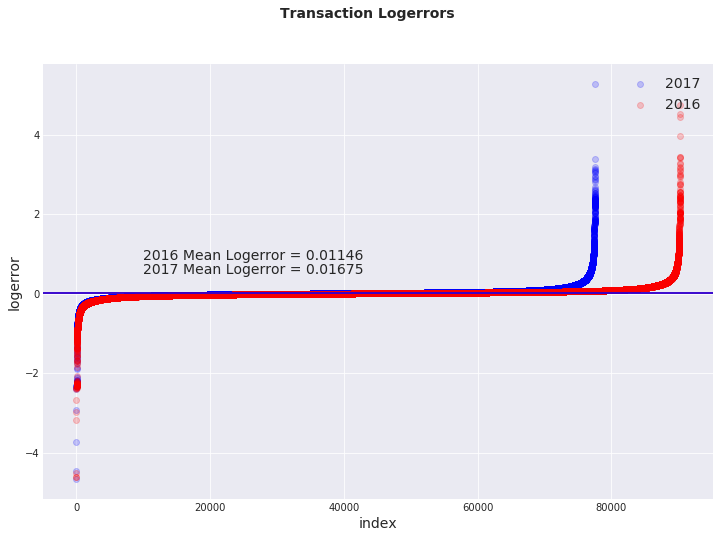

In [7]:
y_mean_2016 = np.mean(df_train_2016.logerror.values)
y_mean_2017 = np.mean(df_train_2017.logerror.values)

fig = plt.figure(figsize=(12,8))
fig.suptitle('Transaction Logerrors', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
plt.scatter(range(df_train_2017.shape[0]), np.sort(df_train_2017.logerror.values), 
            alpha=0.2, color='blue', label='2017')
plt.scatter(range(df_train_2016.shape[0]), np.sort(df_train_2016.logerror.values), 
            alpha=0.2, color='red', label='2016')
#plt.scatter(range(df_train_2017.shape[0]), np.sort(df_train_2017.logerror.values), 
#            alpha=0.2, color='blue', label='2017')

plt.xlabel('index', fontsize=14)
plt.ylabel('logerror', fontsize=14)
ax.text(10000, 0.85, r'2016 Mean Logerror = {n:.{d}f}'.format(n=y_mean_2016, d=5) , fontsize=14)
plt.axhline(y=y_mean_2016, color='red', linestyle='-')
ax.text(10000, 0.5, r'2017 Mean Logerror = {n:.{d}f}'.format(n=y_mean_2017, d=5) , fontsize=14)
plt.axhline(y=y_mean_2016, color='blue', linestyle='-')
plt.legend(loc='upper right', fontsize=14)
plt.show()

For the vast majority of transactions, the logerror was quite small. There are some large outliers within both 2016 and 2017 datasets. 

Let's plot the distributions of logerrors as histograms. We will group the highest 1% of all logerrors together and the lowest 1% to make visualization easier. 

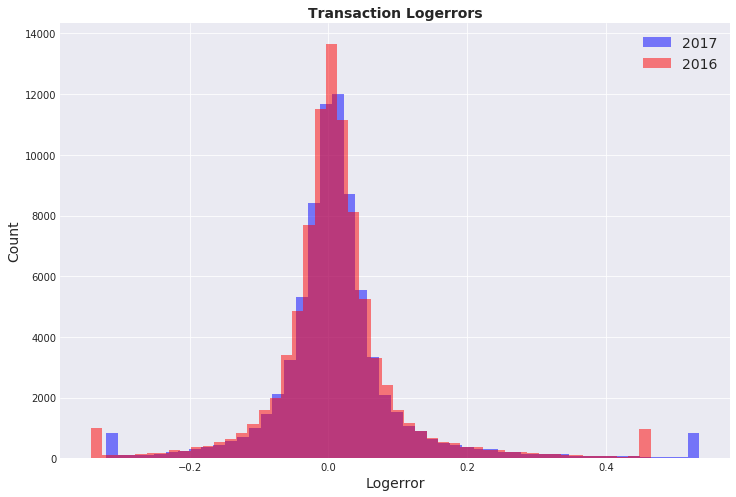

In [8]:
upper_limit_2016 = np.percentile(df_train_2016.logerror.values, 99)
lower_limit_2016 = np.percentile(df_train_2016.logerror.values, 1)
df_train_2016['logerror'].loc[df_train_2016['logerror']>upper_limit_2016] = upper_limit_2016
df_train_2016['logerror'].loc[df_train_2016['logerror']<lower_limit_2016] = lower_limit_2016

upper_limit_2017 = np.percentile(df_train_2017.logerror.values, 99)
lower_limit_2017 = np.percentile(df_train_2017.logerror.values, 1)
df_train_2017['logerror'].loc[df_train_2017['logerror']>upper_limit_2017] = upper_limit_2017
df_train_2017['logerror'].loc[df_train_2017['logerror']<lower_limit_2017] = lower_limit_2017

plt.figure(figsize=(12,8))
plt.title('Transaction Logerrors', fontsize=14, fontweight='bold')
plt.hist(df_train_2017.logerror.values, bins=50, alpha=0.5, color='blue', label='2017')
plt.hist(df_train_2016.logerror.values, bins=50, alpha=0.5, color='red', label='2016')
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Logerror', fontsize=14)
plt.show()


We can compare the number of transactions that occured in each month:

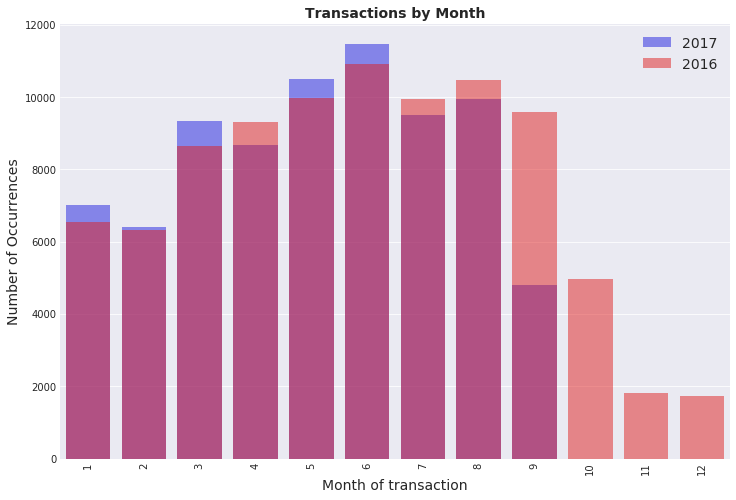

In [9]:
df_train_2016['transaction_month'] = df_train_2016['transactiondate'].dt.month
df_train_2017['transaction_month'] = df_train_2017['transactiondate'].dt.month

month_cnt_2016 = df_train_2016['transaction_month'].value_counts()
month_cnt_2017= df_train_2017['transaction_month'].value_counts()

plt.figure(figsize=(12,8))
plt.title('Transactions by Month', fontsize=14, fontweight='bold')
sns.barplot(month_cnt_2017.index, month_cnt_2017.values, alpha=0.5, color='blue', label='2017')
sns.barplot(month_cnt_2016.index, month_cnt_2016.values, alpha=0.5, color='red', label='2016')
plt.xticks(rotation='vertical')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('Month of transaction', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.show()

The months of January and February for both 2016 and 2017 did not see as many transactions as the other months, perhaps as these are the coldest months, and fewer people are moving. There may be other seasonality effects that play a part in the number of homes sold. 

October-December 2016 appear to have greatly reduced sales, but this is not true. As discussed in the introduction, some of the Zestimates for these months were withheld from contestants. These Zestimates were used to test submissions made during stage 1, and build the public leaderboard. 

Now we will see how logerrors change over time. We will plot the average absolute value for each month's logerrors instead of the average logerrors themselves, as there are both positive and negative logerrors. 

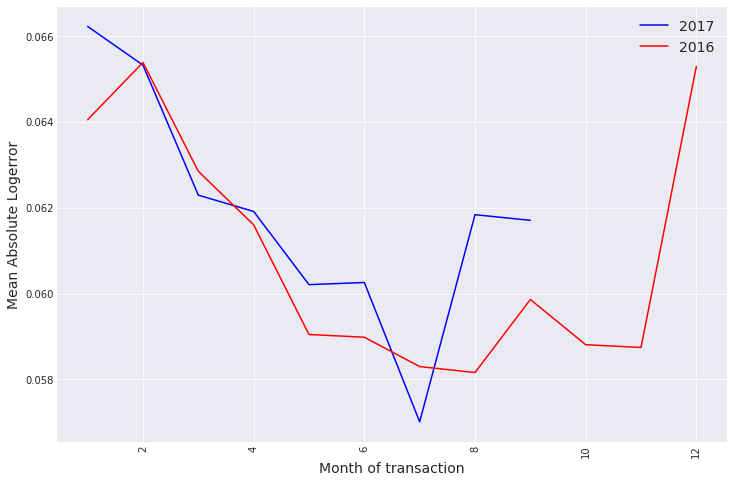

In [10]:
month_avg_2016 = []
month_avg_2017 = []
for i in range(1,13):
    temp_mean = abs(df_train_2016['logerror'][df_train_2016['transaction_month']==i]).mean()
    month_avg_2016.append(temp_mean)
    try:
        temp_mean = abs(df_train_2017['logerror'][df_train_2017['transaction_month']==i]).mean()
        month_avg_2017.append(temp_mean)
    except:
        pass

plt.figure(figsize=(12,8))    
plt.plot(np.arange(1,13), month_avg_2017, 'blue', label='2017')
plt.plot(np.arange(1,13), month_avg_2016, 'red', label='2016')
plt.xticks(rotation='vertical')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('Month of transaction', fontsize=14)
plt.ylabel('Mean Absolute Logerror', fontsize=14)
plt.show()

From this plot we can see that the errors of predictions for the winter months are higher than those for the summer months.

Let's take a look at the data Zillow provided contestants for the ~3 million homes for the year 2016.


In [11]:
df_prop_2016 = pd.read_csv("../input/properties_2016.csv", low_memory=False)
print('2016 properties shape: ', df_prop_2016.shape)
df_prop_2016.head()

2016 properties shape:  (2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


We can see how many of the data fields contain integer values, floating point values, or other objects such as categorical values.

In [12]:
df_dtype = df_prop_2016.dtypes.reset_index()
df_dtype.columns = ['Count', 'Column Type']
df_dtype.groupby('Column Type').aggregate('count').reset_index()

,Column Type,Count
0,int64,1
1,float64,52
2,object,5


The data for the same ~3 million homes for the year of 2017 are quite similar.

In [13]:
df_prop_2017 = pd.read_csv("../input/properties_2017.csv", low_memory=False)
print('2017 properties shape: ', df_prop_2017.shape)
df_prop_2017.head()

2017 properties shape:  (2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


The same 58 properties (or features) are given for both 2016 and 2017. However, the values change somewhat from 2016 to 2017. There are lots of NaN (nonexistent) values present, so let's see what properties have the most values present.

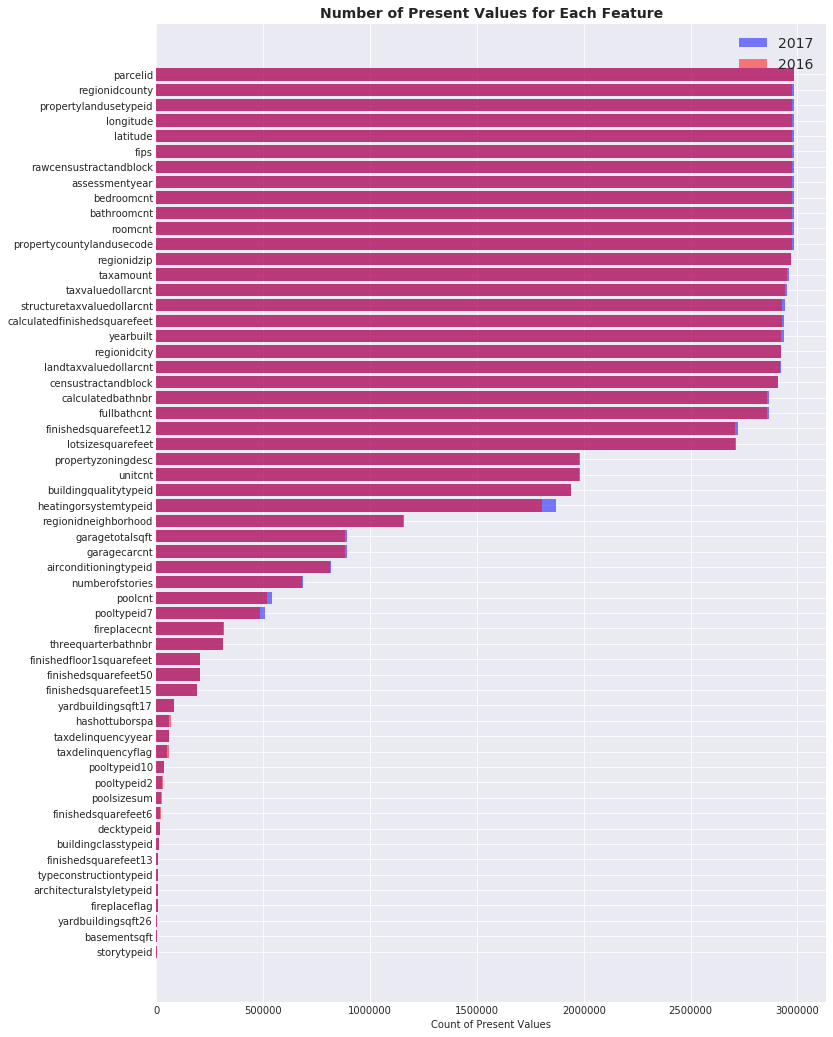

In [14]:
df_present_2016 = df_prop_2016.notnull().sum(axis=0).reset_index()
df_present_2016.columns = ['column_name', 'present_count']
df_present_2016 = df_present_2016.loc[df_present_2016['present_count']>0]
df_present_2016 = df_present_2016.sort_values(by='present_count')

df_present_2017 = df_prop_2017.notnull().sum(axis=0).reset_index()
df_present_2017.columns = ['column_name', 'present_count']
df_present_2017 = df_present_2017.loc[df_present_2017['present_count']>0]
df_present_2017 = df_present_2017.sort_values(by='present_count')


ind = np.arange(df_present_2016.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
ax.barh(ind, df_present_2017.present_count.values, alpha=0.5, color='blue', label='2017')
ax.barh(ind, df_present_2016.present_count.values, alpha=0.5, color='red', label='2016')
ax.legend(loc='upper right', fontsize=14)
ax.set_yticks(ind)
ax.set_yticklabels(df_present_2016.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of Present Values")
ax.set_title("Number of Present Values for Each Feature", fontsize=14, fontweight='bold')


plt.show()

Now let's see how many bathrooms the homes have. **Note** that I have clipped the bathroom count so that all of the homes with 5.5 baths or more will be represented in the '5.5' column. 

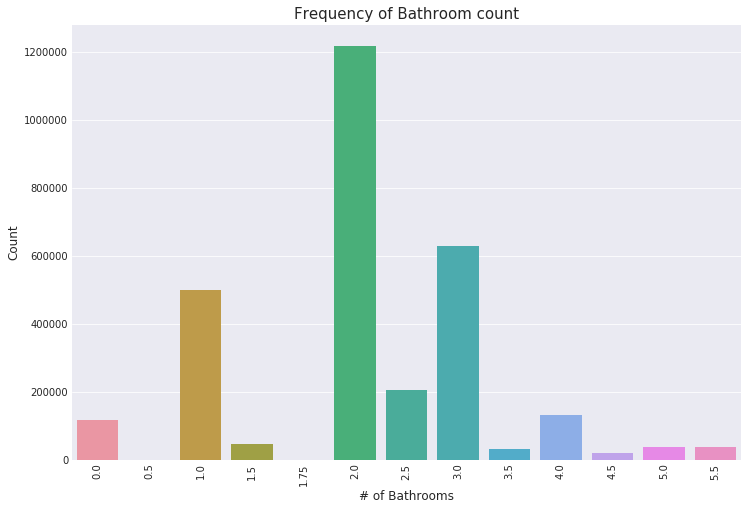

In [15]:
plt.figure(figsize=(12,8))
df_bedbath_2016 = df_prop_2016[['bathroomcnt', 'bedroomcnt']]
df_bedbath_2016['bathroomcnt'] = df_bedbath_2016['bathroomcnt'].clip(upper=5.5)
sns.countplot(x='bathroomcnt', data=df_bedbath_2016)
plt.ylabel('Count', fontsize=12)
plt.xlabel('# of Bathrooms', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

It appears as though there are many homes that do not have a single bathroom! This may be accurate, but it is more likely that there were some problems with the way these data were collected.

It is difficult to see from this plot if there are any homes that have only a half bath or if they have a full bath plus another three-quarter bath.

In [16]:
bath_05 = df_bedbath_2016['bathroomcnt'][(df_bedbath_2016['bathroomcnt']==0.5)].count()
bath_175 = df_bedbath_2016['bathroomcnt'][(df_bedbath_2016['bathroomcnt']==1.75)].count()
print('There are {} homes with only a half bathroom.'.format(bath_05))
print('There are {} homes with a full bath and another three-quarter bath.'.format(bath_175))

There are 17 homes with only a half bathroom.
There are 5 homes with a full bath and another three-quarter bath.


We will also examine the number of bedrooms homes contain. **Note** that I have clipped the bedroom count so that all of the homes with 7 bedrooms or more will be represented in the '7.0' column. 

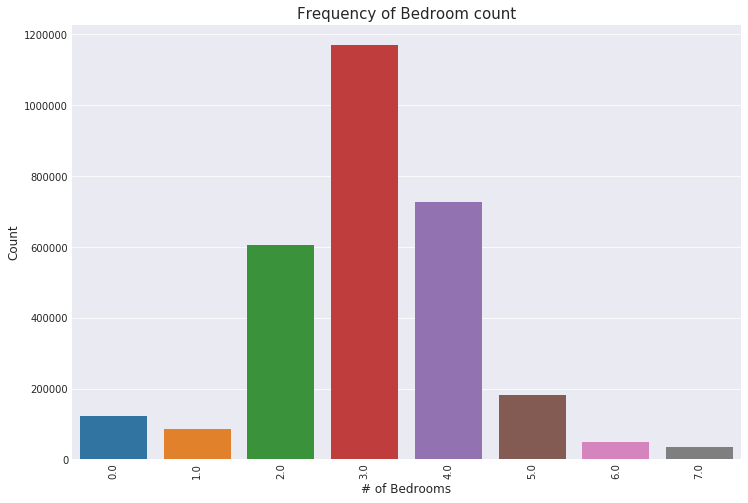

In [17]:
plt.figure(figsize=(12,8))
df_bedbath_2016 = df_prop_2016[['bathroomcnt', 'bedroomcnt']]
df_bedbath_2016['bedroomcnt'] = df_bedbath_2016['bedroomcnt'].clip(upper=7)
sns.countplot(x='bedroomcnt', data=df_bedbath_2016)
plt.ylabel('Count', fontsize=12)
plt.xlabel('# of Bedrooms', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

Homes analyzed in the project are in the Los Angeles area, but exactly where? It would be very helpful to map these homes out geographically. To map all ~3 million points could really bog down this notebook, so we should reduce the number of points that will be plotted. We can use k means clustering to find the geographic centers of groups of points, and plot those centers. The resulting map won't be as accurate, but will be good enough for our purposes. Below we find 400 geographic cluster centers and plot them as a heatmap.

In [18]:
df_geo = df_prop_2016[['latitude', 'longitude']]
df_geo['logerror'] = df_train_2016['logerror']
df_geo['longitude']/=1e6
df_geo['latitude']/=1e6
df_geo.dropna(subset=['latitude','longitude'], axis=0 ,inplace=True)

kmeans = MiniBatchKMeans(n_clusters=400, batch_size=1000).fit(df_geo[['latitude','longitude']])
lst_clusters = kmeans.cluster_centers_.tolist()

heatmap = folium.Map(location=[34.1, -118.5], zoom_start=6)
heatmap.add_child(HeatMap(lst_clusters, radius=15))    

heatmap



Here is a closer look with some geographic features. 

In [19]:
heatmap_2 = folium.Map(location=[34.1, -118.5], zoom_start=8, tiles='Stamen Terrain')
heatmap_2.add_child(HeatMap(lst_clusters, radius=15))    

heatmap_2

This concludes my exploritory data analysis for the Zillow Prize competition, hosted by Kaggle. There are other data processing and machine learning methods that I employed to make my predictions, but I did not discuss them here. Stay tuned for more information once the competition is over. 

Thanks for reading my notebook!